In [24]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [25]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 cricketers worldwide: {topic}."""
performances_prompt = """Generate the most important performance of them  {subject}"""
best_performances_prompt = """Below are a bunch of performances on {topic}. Select the most interesting one! Return the ID of the most interesting one, starting 0 as the ID for the first one. performances: \n\n  {performances}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [26]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class Bestperformances(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    performances: Annotated[list, operator.add]
    best_selected_performances: str

In [27]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [28]:
from langgraph.types import Send
def continue_to_performances(state: OverallState):
    return [Send("generate_performances", {"subject": s}) for s in state["subjects"]]

In [29]:
class performancesState(TypedDict):
    subject: str

class performances(BaseModel):
    performances: str

def generate_performances(state: performancesState):
    prompt = performances_prompt.format(subject=state["subject"])
    response = model.with_structured_output(performances).invoke(prompt)
    return {"performances": [response.performances]}

In [30]:
def best_performances(state: OverallState):
    performancess = "\n\n".join(state["performances"])
    prompt = best_performances_prompt.format(topic=state["topic"], performances=performances)
    response = model.with_structured_output(Bestperformances).invoke(prompt)
    return {"best_selected_performances": state["performances"][response.id]}

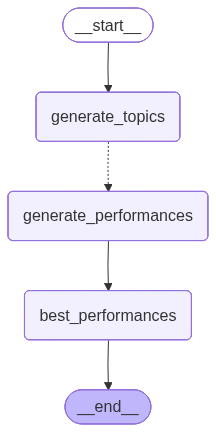

In [31]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_performances", generate_performances)
graph.add_node("best_performances", best_performances)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_performances, ["generate_performances"])
graph.add_edge("generate_performances", "best_performances")
graph.add_edge("best_performances", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [32]:
# Call the graph: here we call it to generate a list of performancess
for s in app.stream({"topic": "best odi batsmen"}):
    print(s)

{'generate_topics': {'subjects': ['**1. Virat Kohli (India):**\n   - Known for his aggressive batting style and consistency, Virat Kohli has been a dominant force in ODI cricket. His ability to chase down targets and play under pressure has earned him numerous accolades and records.\n   - Key Achievements: Over 12,000 ODI runs, multiple ICC awards, and numerous centuries.\n\n**2. Babar Azam (Pakistan):**\n   - Babar Azam has quickly risen through the ranks to become one of the most stylish and technically sound batsmen in the world. His elegant stroke play and ability to anchor innings make him a crucial player for Pakistan.\n   - Key Achievements: Fastest to 1000 runs in T20Is, consistent top-order performances, and captain of the national team.\n\n**3. Kane Williamson (New Zealand):**\n   - Renowned for his calm demeanor and strategic acumen, Kane Williamson is a master of pacing an innings. His ability to adapt to different conditions and situations makes him a valuable asset in ODI